In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import pickle
# from google.colab import drive
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from scipy.spatial import distance
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [5]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [7]:
# Function to resize images
def resize_images(directory, target_size):
    resized_images = []
    labels = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, target_size)
        resized_images.append(resized_image)
        labels.append(0 if 'original' in directory else 1)  # Assign label 0 for original images and 1 for fraud images
    return np.array(resized_images), np.array(labels)

In [8]:
# Function to create output directories if not present
def create_output_directories(output_dirs):
    for dir_path in output_dirs:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            print(f"Created directory: {dir_path}")

In [9]:
# # Function to save preprocessed images
# def save_preprocessed_images(images, output_dir):
#     for i, img in enumerate(images):
#         cv2.imwrite(os.path.join(output_dir, f"image_{i}.jpg"), img)


# Function to save preprocessed images
def save_preprocessed_images(images, output_dir, filenames):
    for filename, img in zip(filenames, images):
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, img)

In [10]:
# Paths to your dataset folders (update these paths according to your folder structure in Google Drive)
original_dataset_dir = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\original'
fraud_dataset_dir = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\fraud'
# verification_dir = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\verification'

In [11]:
# Output directories for preprocessed images
preprocessed_original_dir = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\preprocessed_original'
preprocessed_fraud_dir = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\preprocessed_fraud'
# preprocessed_verification_dir = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\preprocessed_verification'

In [12]:
# Create output directories if not present
# create_output_directories([preprocessed_original_dir, preprocessed_fraud_dir, preprocessed_verification_dir])
create_output_directories([preprocessed_original_dir, preprocessed_fraud_dir])

In [13]:
# Resize images in original dataset folder
original_images, original_labels = resize_images(original_dataset_dir, IMAGE_SIZE)

# Resize images in fraud dataset folder
fraud_images, fraud_labels = resize_images(fraud_dataset_dir, IMAGE_SIZE)

# Resize images in verification folder
# verification_images, verification_labels = resize_images(verification_dir, IMAGE_SIZE)

In [14]:
# Concatenate all images and labels
# all_images = np.concatenate([original_images, fraud_images, verification_images])
# all_labels = np.concatenate([original_labels, fraud_labels, verification_labels])
all_images = np.concatenate([original_images, fraud_images])
all_labels = np.concatenate([original_labels, fraud_labels])

In [15]:
# # Preprocess the images for VGG16
# preprocessed_images = preprocess_input(all_images)

# # Save preprocessed images in respective folders
# save_preprocessed_images(original_images, preprocessed_original_dir)
# save_preprocessed_images(fraud_images, preprocessed_fraud_dir)
# save_preprocessed_images(verification_images, preprocessed_verification_dir)

# Save preprocessed images in respective folders
save_preprocessed_images(original_images, preprocessed_original_dir, os.listdir(original_dataset_dir))
save_preprocessed_images(fraud_images, preprocessed_fraud_dir, os.listdir(fraud_dataset_dir))
# save_preprocessed_images(verification_images, preprocessed_verification_dir, os.listdir(verification_dir))


# Initialize the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

In [16]:
# Extract features using VGG16
features = base_model.predict(all_images, batch_size=BATCH_SIZE)

19/19 [==============================] - 83s 4s/step


In [17]:
# Flatten extracted features
flattened_features = features.reshape(features.shape[0], -1)

In [18]:
# Print the shape of extracted features
print("Shape of extracted features:", flattened_features.shape)

Shape of extracted features: (607, 25088)


CNN Model


In [19]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

In [20]:
# Set the paths to your dataset folders
real_path = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\preprocessed_original'
forge_path = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\preprocessed_fraud'

real_images = []
for img_name in os.listdir(real_path):
    img = cv2.imread(os.path.join(real_path, img_name), cv2.IMREAD_GRAYSCALE)
    real_images.append(img)
real_images = np.array(real_images, dtype=object)

forge_images = []
for img_name in os.listdir(forge_path):
    img = cv2.imread(os.path.join(forge_path, img_name), cv2.IMREAD_GRAYSCALE)
    forge_images.append(img)
forge_images = np.array(forge_images, dtype=object)

In [21]:
real_labels = np.zeros(real_images.shape[0])
forge_labels = np.ones(forge_images.shape[0])

X = np.concatenate((real_images, forge_images), axis=0)
y = np.concatenate((real_labels, forge_labels), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
import cv2
import numpy as np

# load the dataset
real_path = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\preprocessed_original'
forge_path = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\preprocessed_fraud'

# set the image size to 128x128
img_size = (128, 128)

real_images = []
for img_name in os.listdir(real_path):
    img = cv2.imread(os.path.join(real_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    real_images.append(img)
real_images = np.array(real_images)

forge_images = []
for img_name in os.listdir(forge_path):
    img = cv2.imread(os.path.join(forge_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    forge_images.append(img)
forge_images = np.array(forge_images)

# normalize the data
real_images = real_images.astype('float32') / 255.0
forge_images = forge_images.astype('float32') / 255.0

In [23]:
import numpy as np

num_real_images = len(real_images)
num_forge_images = len(forge_images)

# Create labels for the real and forged signatures
real_labels = np.zeros(num_real_images, dtype=int)
forge_labels = np.ones(num_forge_images, dtype=int)

# Concatenate the real and forged images and labels
X = np.concatenate((real_images, forge_images), axis=0)
y = np.concatenate((real_labels, forge_labels), axis=0)

In [24]:
import numpy as np

# create dummy data
X_train = np.random.rand(40, 128, 128)

# add another dimension to the array
X_train = np.expand_dims(X_train, axis=-1)

# reshape the array
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)

print(X_train.shape)  # output: (40, 128, 128, 1)

(40, 128, 128, 1)


In [25]:
import numpy as np

# create dummy data
X_test = np.random.rand(40, 128, 128)

# add another dimension to the array
X_test = np.expand_dims(X_test, axis=-1)

# reshape the array
X_test = X_train.reshape(X_test.shape[0], 128, 128, 1)

print(X_train.shape)  # output: (40, 128, 128, 1)

(40, 128, 128, 1)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a Sequential model
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 1)))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Add another convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer with 128 neurons and a relu activation function
model.add(Dense(units=128, activation='relu'))

# Add a dropout layer to reduce overfitting
model.add(Dropout(rate=0.5))

# Add the output layer with a sigmoid activation function
model.add(Dense(units=1, activation='sigmoid'))

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
8/8 [==============================] - 3s 291ms/step - loss: 1.0031 - accuracy: 0.4917 - val_loss: 0.6932 - val_accuracy: 0.5082
Epoch 2/10
8/8 [==============================] - 2s 262ms/step - loss: 0.6938 - accuracy: 0.5167 - val_loss: 0.6922 - val_accuracy: 0.4918
Epoch 3/10
8/8 [==============================] - 2s 265ms/step - loss: 0.6921 - accuracy: 0.5042 - val_loss: 0.6890 - val_accuracy: 0.5082
Epoch 4/10
8/8 [==============================] - 2s 275ms/step - loss: 0.6809 - accuracy: 0.5792 - val_loss: 0.7042 - val_accuracy: 0.4918
Epoch 5/10
8/8 [==============================] - 3s 333ms/step - loss: 0.7105 - accuracy: 0.5167 - val_loss: 0.6810 - val_accuracy: 0.6066
Epoch 6/10
8/8 [==============================] - 3s 321ms/step - loss: 0.6687 - accuracy: 0.6333 - val_loss: 0.6762 - val_accuracy: 0.5738
Epoch 7/10
8/8 [==============================] - 3s 319ms/step - loss: 0.6347 - accuracy: 0.6667 - val_loss: 0.7551 - val_accuracy: 0.5574
Epoch 8/10
8/8 [====

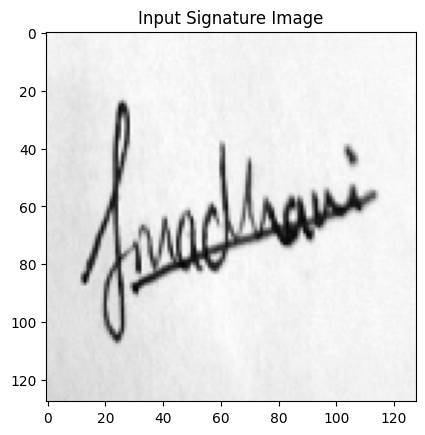

1/1 [==============================] - 0s 81ms/step
The signature is forged.


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to predict whether an image is real or forged
def predict_signature(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        return "Error: Unable to load the image."

    img = cv2.resize(img, (128, 128))
    img = np.array(img).reshape(1, 128, 128, 1) / 255.0

    # Display the image
    plt.imshow(img.reshape(128, 128), cmap='gray')
    plt.title("Input Signature Image")
    plt.show()

    # Predict the class of the signature image
    prediction = model.predict(img)

    return "The signature is real." if prediction < 0.5 else "The signature is forged."

# Allow user input for image file name
image_name = input("Enter the image file name (e.g., Og/Fk.jpg): ")

# Construct the full image path based on the provided name
image_path = 'C:\\Users\\Smit\\Desktop\\SFDS\\Customized_Dataset\\preprocessed_verification\\' + image_name

# Call the prediction function
result = predict_signature(image_path)
print(result)


In [30]:
# Save the entire model to a file
model.save('model.h5')